In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import hdgal
import lsstutils
import lsst.daf.persistence
from astroquery.skyview import SkyView
from astropy.visualization import make_lupton_rgb
from astropy.coordinates import SkyCoord
from astropy import units as u
plt.style.use('jpg')

In [20]:
import hdgal

In [2]:
cat = pd.read_csv('../../hsc-diffuse-galaxies/data/final-sample/hsc-lsbg-final-cat.csv')
cat.drop('id', axis=1, inplace=True)
cat.rename(columns={'cat-id':'id'}, inplace=True)
cat.set_index('id', drop=True, inplace=True)

In [3]:
ids = np.array([662, 522, 605, 40, 614, 741, 745, 515, 540, 497])

In [4]:
butler = lsst.daf.persistence.Butler('/Volumes/HSC-rerun-20160523/')
skymap = butler.get('deepCoadd_skyMap', immediate=True)

Config override file '?' appears to use 'root' instead of 'config'; trying with 'root'

In [34]:
size = 66

In [33]:
if False:
    stamps = []
    for ra, dec, r_e in cat.loc[ids, ['ra', 'dec', 'r_e']].values:
        gri = {}
        for b in 'gri':
            gri[b] = lsstutils.make_stamp(ra, dec, (size/2.0)*u.arcsec, band=b, butler=butler, skymap=skymap)

        stamps.append(gri)
    for count, (id, row) in enumerate(cat.loc[ids].iterrows()):
        for b in 'gri':
            stamps[0][b].writeFits('/Users/protostar/local_data/gemini-2018A-data/lsbg-'+str(id)+'-'+b+'.fits')

In [11]:
import lsst.afw.display.rgb as afwRgb

In [81]:
dataRange=0.6
Q=5

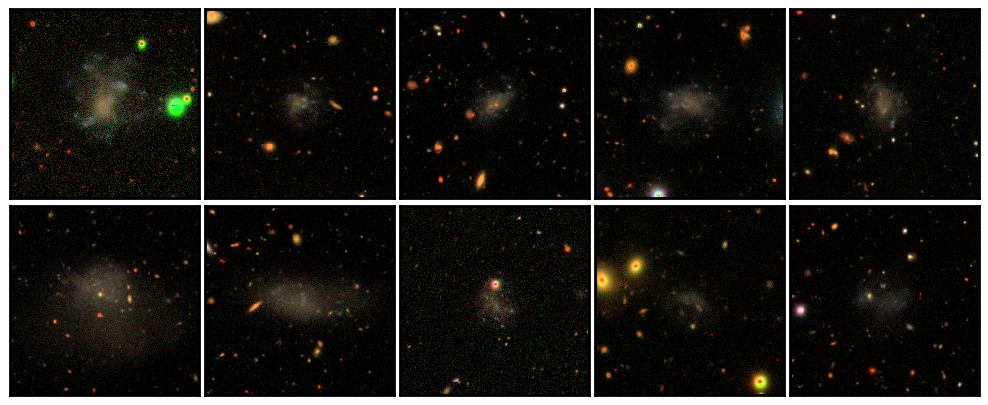

In [28]:
fig, axes = plt.subplots(2, 5, figsize=(5*2.5, 5), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(hspace=0.03, wspace=0.03)
axes = axes.flatten()

for count, (id, row) in enumerate(cat.loc[ids].iterrows()):
    img = [stamps[count][b].getMaskedImage().getImage().getArray() for b in 'irg']
    vmin, vmax = np.percentile(img, [0.1, 99])
    rgb = afwRgb.makeRGB(img[0], img[1], img[2], dataRange=1.0, Q=5)
    axes[count].imshow(rgb, vmin=vmin, vmax=vmax, origin='lower', cmap='gray_r')

In [41]:
survey_order = ['GII', 'NGS', 'DIS', 'MIS', 'AIS']

In [82]:
images = []
stretch = dataRange

for cat_id in ids:
    
    ra, dec = cat.loc[cat_id, ['ra', 'dec']]
    coord = SkyCoord(ra, dec, unit='deg')


    sdss_images = SkyView.get_images(coord, 
                                     survey=['SDSSg', 'SDSSr', 'SDSSi'],
                                     pixels=str(int(size/0.4)))

    sdss = make_lupton_rgb(sdss_images[2][0].data,
                           sdss_images[1][0].data,
                           sdss_images[0][0].data,
                           stretch=stretch, 
                           Q=Q)

    for survey in survey_order:
        if cat_id==741 and survey=='GII':
            continue
        elif cat_id==40 and survey=='GII':
            continue

        galex = hdgal.fetch_galex_cutout(ra, dec, size, survey=survey)
        if galex is not None:
            break

    images.append([sdss, galex])

images = np.array(images)

**** No GII image found at 128.47116336 -0.390167715157 ****
**** No NGS image found at 128.47116336 -0.390167715157 ****
**** No DIS image found at 128.47116336 -0.390167715157 ****
**** No MIS image found at 128.47116336 -0.390167715157 ****
**** No NGS image found at 236.741205933 42.5972292793 ****
**** No DIS image found at 236.741205933 42.5972292793 ****
**** No GII image found at 211.57208121 0.629449978931 ****
**** No NGS image found at 211.57208121 0.629449978931 ****
**** No DIS image found at 211.57208121 0.629449978931 ****
**** No NGS image found at 180.418708052 -1.20433369006 ****
**** No DIS image found at 180.418708052 -1.20433369006 ****
**** No GII image found at 139.73086798 1.75158034488 ****
**** No NGS image found at 139.73086798 1.75158034488 ****
**** No DIS image found at 139.73086798 1.75158034488 ****


In [77]:
hsc_images = []
for count in range(10):
    img = [stamps[count][b].getMaskedImage().getImage().getArray() for b in 'irg']
    vmin, vmax = np.percentile(img, [0.1, 99])
    hsc_images.append(afwRgb.makeRGB(img[0], img[1], img[2], dataRange=0.6, Q=Q))
hsc_images = np.array(hsc_images)

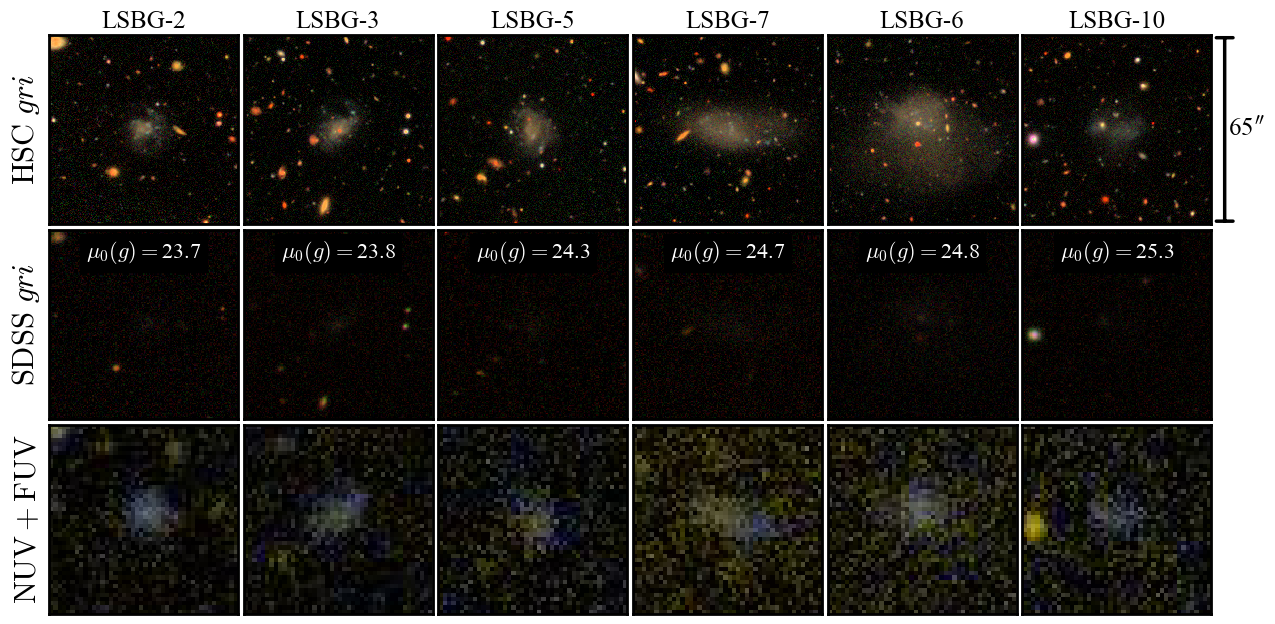

In [83]:
num_obj = 6
fig, axes = plt.subplots(3, num_obj, figsize=(15, 15*3./num_obj), 
                         subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.03, hspace=0.02)

fs = 18
idx = [1, 2, 4, 6, 5, 9]

for col, (sdss, galex) in enumerate(images[idx]):
    hsc = hsc_images[idx][col]
    
    kws = dict(origin='lower')
    axes[0, col].imshow(hsc, **kws)
    axes[1, col].imshow(sdss, **kws)
    axes[2, col].imshow(galex, **kws)
    
    cat_id = ids[idx][col]
    mu0 = cat.loc[cat_id, 'mu_0_forced_g'] 
    axes[0, col].set_title('LSBG-'+str(idx[col]+1), fontsize=fs)
    axes[1, col].text(0.5, 0.85, r'$\mu_0(g) = $'+str(round(mu0, 1)), color='w',
                      backgroundcolor='k', transform=axes[1, col].transAxes, 
                      fontsize=16, ha='center')
    
axes[0, 0].set_ylabel(r'$\mathrm{HSC}\ gri$', fontsize=fs+4)
axes[1, 0].set_ylabel(r'$\mathrm{SDSS}\ gri$', fontsize=fs+4)
axes[2, 0].set_ylabel(r'$\mathrm{NUV+FUV}$', fontsize=fs+4)

axes[0, -1].annotate('', xy=(1.07, 0), xycoords='axes fraction', xytext=(1.07, 1), 
                    arrowprops=dict(arrowstyle="|-|,widthA=0.6,widthB=0.6", color='k', lw=2.5))
axes[0, -1].text(1.09, 0.5, str(int(size)-1)+r'$^{\prime\prime}$', 
                transform=axes[0, -1].transAxes, fontsize=18, ha='left', va='center')

fig.savefig('/Users/protostar/Dropbox/Apps/ShareLaTeX/Gemini-Proposal-LSB-2018A/targets.pdf')